# [4] NeRF Network

## 1. Positional Encoding

아래 코드는 NeRF 논문의 **Positional Encoding** 기법을 파이썬 클래스(`Embedder`)로 구현한 예시입니다.  
**목표**는 3차원 벡터(예: 위치 $\mathbf{p}$ 또는 방향 $\mathbf{d}$)에 대해, 다음과 같은 형태의 트리그 함수(사인/코사인) 묶음을 만들어 고차원 벡터로 확장하는 것입니다.

$$
\gamma(\mathbf{p})
= \Bigl[
\mathbf{p},\;
\sin(2^0 \pi \mathbf{p}), \cos(2^0 \pi \mathbf{p}),\;
\sin(2^1 \pi \mathbf{p}), \cos(2^1 \pi \mathbf{p}),\;
\cdots,\;
\sin(2^{L-1} \pi \mathbf{p}), \cos(2^{L-1} \pi \mathbf{p})
\Bigr].
$$

위 식에서:
- $\mathbf{p}$의 차원이 3 (x,y,z)라면, 각 주파수(frequency)마다 $\sin, \cos$ 각각 3차원씩 6차원이 추가됩니다.  
- $L$개의 주파수가 있으면 총 $2L \times 3$ 차원을 얻게 되고, “원본 $\mathbf{p}$ 포함 여부”(`include_input`)에 따라 추가 3차원이 붙어서 최종 63차원(예: $L=10$일 때) 정도가 됩니다.  
아래는 **코드 상세 해설**입니다.

### 1) Embedder 클래스
**`__init__`:** 인스턴스 생성에 필요한 kwargs를 받아 초기화(입력 차원, 옥타브 수, 주기 함수의 종류 등)

**`create_embedding_fn`:** 입력 데이터를 태울 지수 함수와 삼각 함수 리스트를 인스턴스 변수로 생성하여 저장

**`embed`:** 실제로 입력 데이터를 받고, 임베딩 함수의 리스트로 구성된 인스턴스 변수에 태워 실제 임베딩 결과값을 반환

왜 굳이 create_embedding_fn와 embed를 구분하여 코드를 설계하였는가?
1. **초기화 단계 vs. 실행 단계**를 **명확히 분리**  
   - `create_embedding_fn`는 “어떤 주파수 대역을 쓸 것인지?”, “사인·코사인 등 어떤 함수를 쓸 것인지?”를 결정하고, 그에 맞는 **람다 함수들을 한 번** 생성해 둡니다.  
   - 이후 실제 데이터를 넣을 때(`.embed()` 호출 시), 이미 만들어진 함수를 재사용하여 **빠르게** 인코딩을 수행할 수 있습니다. 

2. **반복 호출 효율**  
   - 만약 매번 입력이 들어올 때마다(예: 매 배치마다) “사인·코사인 함수를 생성·세팅” 한다면 오버헤드가 큽니다.  
   - 반면 초기 한 번(`create_embedding_fn`)만 람다들을 생성해두고, `.embed(...)`에서는 “이미 만들어진 함수 리스트”를 순회하기만 하면 되므로 **코드 재사용**과 **효율**이 좋아집니다.

In [1]:
import torch
# torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Positional encoding (section 5.1)
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs # “몇 차원의 입력을 받을지?”, “몇 개의 주파수를 사용할지?”, “어떤 함수를 쓸지?(sin, cos 등)” 등의 설정
        self.create_embedding_fn() # 바로 create_embedding_fn()을 호출하여 실제 인코딩 함수를 만든다.
        
    def create_embedding_fn(self):
        embed_fns = [] # 임베딩 할 함수들을 담는 리스트
        d = self.kwargs['input_dims'] # 입력 차원. view dir과 카메라 위치 좌표 모두 3차원이다.
        out_dim = 0 # 최종 Positional Encoding의 출력 차원을 추적하기 위한 변수로, 초기 값은 0으로 세팅.

        if self.kwargs['include_input']: # 단순히 인풋 값을 아웃풋에 추가할 것인지.
            embed_fns.append(lambda x : x) # 인코딩 벡터에 인풋값인 X, Y, Z 좌표를 추가해준다. (즉, 60차원이 아닌 63차원으로 return)
            out_dim += d # out_dim에 3 더하여 추적 업데이트.

        # L과 L-1을 정해준다. (하단의 embed_kwargs 참조)
        max_freq = self.kwargs['max_freq_log2'] # = max_freq = L-1
        N_freqs = self.kwargs['num_freqs'] # N_freqs = Octave = L

        if self.kwargs['log_sampling']: # 로그 샘플링
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
            # 0부터 max_freq(=L-1)까지 N_freqs개를 2의 제곱에 모두 태우는 것.
        else: # 리니어 샘플링
            freq_bands = torch.linspace(2.**0, 2.**max_freq, step=N_freqs)
            # 0부터 max_freq(L-1)까지 N_freqs개를 단순히 리니어 샘플링 한다.
            # 실제 코드는 있으나 사용하진 않음.

        # 예: max_freq_log2=9, num_freqs=10 → freq_bands = [1, 2, 4, 8, ..., 512(=2^9)]


        # 이제 sin, cos에 태워준다.
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']: # 어떤 함수에 태울 것인가? (논문에선 cos, sin 사용)
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq)) # 수식에는 π까지 붙이는데 여기선 그냥 sin(2^n * x), cos(2^n * x)
                # cf) lambda (input : output)
                out_dim += d

        # 이후 아래의 다른 함수에서 접근할 수 있도록 self 변수에 대입
        self.embed_fns = embed_fns # 포지션 인코딩에 사용할 람다 함수 리스트 (x, sin, cos, ... , sin, cos)
        self.out_dim = out_dim # 포지션 인코딩 된 값의 차원

    # embed_fns에 input 데이터를 넣어 임베딩 된 결과를 도출한 뒤, torch.cat으로 묶어서 반환해주는 함수
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)
        # 여러 개의 람다 함수를 순회하며, 입력벡터 inputs에 대해 각각 사인·코사인을 계산.   
        # 마지막 차원(-1)으로 연결(torch.cat), 즉 shape가 (N, out_dim) 형태가 됨.

        # 예:
        # 입력이 shape (N,3)
        # 주파수 대역이 L=10, include_input=True라면,
        # 최종 출력은 (N, 63).

### 2) get_embedder
이 함수는 위에서 선언한 임베더 클래스의 내부 함수들을 실행시켜 결과를 받아내는 역할을 한다.  
이렇게 선언된 클래스에서 인스턴스를 생성하고, 내부 함수를 수행하는 함수를 헬퍼 함수라고도 부른다.  
헬퍼 함수는 외부 코드에서 직접 인스턴스를 만들고 일일이 인자들을 세팅하는 과정을 하나의 명령어로 컨트롤할 수 있기 때문에 다양한 변인을 바꿔줘야 하는 실험 세팅에 편리함을 준다.

In [2]:
# 위에서 정의한 임베더 클래스에서 객체를 생성한 후, view_o와 view_d를 구분하여 임베딩 해주는 함수.
# view_o와 view_d의 옥타브 (L = multires)의 값이 각각 다르다.
def get_embedder(multires, i = 0): # multires는 옥타브 수
    # 만약 i=-1, 즉 “positional encoding을 쓰지 않겠다”는 상황이면, 항등 함수(nn.Identity())와 출력차원 3을 반환.
    if i == -1:
        return nn.Identity(), 3 # 그냥 같은 값 return.
    
    # -1이 아닌 경우
    # 임베더 인스턴스를 생성하기 전에, 이것이 생성자(__init__)에서 받는 kwargs를 생성해준다.
    embed_kwargs = {
                'include_input' : True, # 원래 input 값을 output에 넣을 것이냐? (60 -> 63)
                'input_dims' : 3, # input_dim은 view_o와 view_d 모두 3차원으로 동일.
                'max_freq_log2' : multires-1, # L - 1
                'num_freqs' : multires, # = L (옥타브 수).
                'log_sampling' : True, # 지수함수에 태울 것인가
                'periodic_fns' : [torch.sin, torch.cos], # 어떤 주기함수에 태울 것인가
    }
    
    embedder_obj = Embedder(**embed_kwargs) # 객체 생성 후 위에서 정의한 kwargs로 초기화
    embed = lambda x, eo=embedder_obj : eo.embed(x) # 임베딩 된 결과값
    
    # embed는 positional encoding 된 값, embedder_obj.out_dim는 예를 들어 63이 나올 것
    return embed, embedder_obj.out_dim

In [3]:
# 카메라 좌표 (X, Y, Z)를 옥타브 10에 태워 임베딩 하는 예제(torch.rand)
embed, out_dim = get_embedder(10,0) # 옥타브 10
# embed: 임베딩 함수
# outdim: 임베딩 차원수
print(embed)
print(out_dim)

input = torch.rand(3)
# embed 함수로 인스턴스 생성부터 결과값
output = embed(input) # 처음 3개는 같고, 그 다음 60개는 sin, cos을 태운 것.

print(input)
print(output)

<function get_embedder.<locals>.<lambda> at 0x7f026b507ee0>
63
tensor([0.5134, 0.5193, 0.7209])
tensor([ 0.5134,  0.5193,  0.7209,  0.4911,  0.4963,  0.6600,  0.8711,  0.8682,
         0.7512,  0.8556,  0.8617,  0.9917,  0.5176,  0.5075,  0.1287,  0.8858,
         0.8745,  0.2552, -0.4641, -0.4850, -0.9669, -0.8222, -0.8482, -0.4936,
        -0.5691, -0.5296,  0.8697,  0.9359,  0.8985, -0.8585, -0.3521, -0.4390,
         0.5127, -0.6592, -0.7889, -0.8804, -0.7520, -0.6145, -0.4742,  0.9914,
         0.9696,  0.8350,  0.1310, -0.2447, -0.5503,  0.2597, -0.4746, -0.9190,
        -0.9657, -0.8802, -0.3943, -0.5015,  0.8354,  0.7248,  0.8651,  0.5496,
        -0.6890, -0.8678,  0.9183, -0.9987,  0.4970, -0.3959, -0.0505])


In [4]:
# 카메라 좌표 (X, Y, Z)를 옥타브 10에 태워 임베딩 하는 예제(torch.zeros)
embed, out_dim = get_embedder(10,0) # 옥타브 10
print(embed)
print(out_dim)
input = torch.zeros(3)
output = embed(input)

print(input)
print(output)

<function get_embedder.<locals>.<lambda> at 0x7f026b511ca0>
63
tensor([0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1.])


In [5]:
# view_dirs를 옥타브 4에 태워 임베딩 하는 예제
embed, out_dim = get_embedder(4, 0) # 뷰 디렉션의 옥타브는 4
print(embed)
print(out_dim)

output = embed(input)

print(input)
print(output)

<function get_embedder.<locals>.<lambda> at 0x7f026b507af0>
27
tensor([0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1.])


## 2. NeRF 네트워크 구현
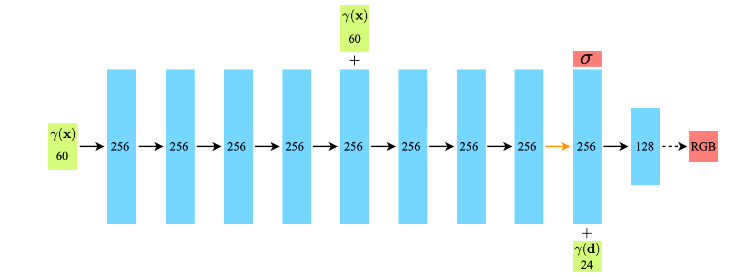

- 처음 인풋 데이터: 시선의 시작점(view_o)  
- 5번째 레이어에서 좌표값을 한 번 더 넣어 정보 희석 방지 
- 마지막 레이어에서 해당 픽셀의 투명도를 산출  
- 마지막 레이어의 인풋으로 시선의 방향(view_d)과 시선의 시작점(view_o) 인풋
- 시선 방향에 대한 아웃풋으로 RGB값을 산출

In [6]:
# Model
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4, skips=[4], use_viewdirs=False): # output_ch=4인 이유는 rgb와 alpha의 4개이므로.
        super(NeRF, self).__init__()
        # 생성자로 받은 인자를 클래스 내부 변수로 저장
        self.D = D # 네트워크의 총 레이어
        self.W = W # 은닉 레이어 너비(채널 수)
        self.input_ch = input_ch # 뷰 위치 차원
        self.input_ch_views = input_ch_views # 뷰 디렉션 차원
        self.skips = skips # 스킵 커넥션 레이어
        self.use_viewdirs = use_viewdirs # 뷰 디렉션 사용 여부 (사용)

        # 위치 좌표의 입력을 처리하는 레이어
        self.pts_linears = nn.ModuleList([nn.Linear(input_ch, W)] +
                                         [nn.Linear(W, W) if i not in self.skips else nn.Linear(W+input_ch, W) for i in range(D-1)])
        # 스킵 레이어가 아니라면 단순히 W -> W 레이어
        # 스킵 레이어라면 W + input_ch -> W 레이어
        # 스킵 커넥션의 성능: 깊은 레이어에서도 초기 입력 좌표의 고주파 정보를 계속 사용할 수 있게 됩니다.

        # 시점 방향 입력을 처리하는 레이어
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W//2)])
        # W + input_ch_view -> W 레이어

        if use_viewdirs: # view_dirs를 사용한다면
            self.feature_linear = nn.Linear(W, W) # W -> W 레이어
            self.alpha_linear = nn.Linear(W, 1) # 하나의 스칼라 값인 알파값을 뽑기 위한 1채널
            self.rgb_linear = nn.Linear(W//2,3) # rgb output을 뽑기 위한 3채널
        else: # view_dirs를 사용하지 않는다면
            # 단일 레이어 (W -> 4)로 RGB값과 알파 값을 같이 추출
            self.output_linear = nn.Linear(W, output_ch) # rgb 알파까지 해서 4채널

    def forward(self, x):
        # input x에는 좌표에 대한 인코딩 값인 self.input_ch와 view dir에 대한 인코딩 값인 self.input_ch_views이 concat 되어있다.
        # 따라서 우선 이걸 torch.split를 dim = -1 (마지막 dim)에서 나눠준다.
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1) # (B, 63), (B, 27)
        
        h = input_pts
        # 인덱스 4 레이어에서 h를 한 번 더 concat 하니까 인덱스를 알기 위해 enum 사용
        for i, l in enumerate(self.pts_linears):
            h = self.pts_linears[i](h) # i번째 레이어에 h를 넣고
            h = F.relu(h) # relu 태워주기
            if i in self.skips: # 인덱스가 self.skips에 포함된다면
                h = torch.cat([input_pts, h], -1) # (B, 63+256)
        # 현재 h: 위치 자표에 대한 W 차원의 output

        # view dirs의 사용 여부(논문에선 사용)
        if self.use_viewdirs:
            alpha = self.alpha_linear(h) # for loop를 다 돌고 나온 h에 self.alpha_linear를 통과시켜 투명도인 alpha를 생성
            # h를 다시 feature layer에 통과시켜 변형
            feature = self.feature_linear(h) # for loop를 다 돌고 나온 h에 self.feature_linear를 통과시켜 feature를 생성
            h = torch.cat([feature, input_views], -1) # feature_linear를 input_views와 concat
            # 위치와 방향 두 가지 정보를 조합해서 rgb 컬러 값을 낸다.
            # 보는 방향이 달라졌을 때, 빛의 반사 등에 의해 같은 지점의 색상도 다르게 보일 수 있으니 방향 정보를 concat 하는 것

            # views_linears를 거쳐 최종 rgb값 산출
            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            # 마지막 rgb 레이어 (256 to 128)
            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], -1)
        else:
            outputs = self.output_linear(h) # view dir를 사용하지 않을 경우 단일 레이어에서 rgb, alpha 모두 얻음.
        
        return outputs

In [7]:
# 인풋 값 생성
input = torch.rand(1,3) # 배치 1, input은 x, y, z로 3
input_dir = torch.rand(1,3) # 배치 1, dir도 3
print(input)
print(input_dir)

# 임베딩 하기
embed, out_dim = get_embedder(10) # 좌표 옥타브는 10
embed_dir, out_dim_dir = get_embedder(4) # 방향 옥타브는 4

# 임베딩한 결과값
emb_input = embed(input)
emb_input_dir = embed_dir(input_dir)
print(emb_input.shape)
print(emb_input_dir.shape)

# 모델 생성
model = NeRF(input_ch=out_dim, input_ch_views=out_dim_dir, use_viewdirs=True)
x = torch.cat([emb_input, emb_input_dir], dim=-1)
print(x.shape)
out = model(x)

print(out.shape) # out은 rgb와 알파 값이 concat 되어 나온다.

tensor([[0.3163, 0.6308, 0.3783]])
tensor([[0.1616, 0.4788, 0.7762]])
torch.Size([1, 63])
torch.Size([1, 27])
torch.Size([1, 90])
torch.Size([1, 4])


In [8]:
# 함수를 return 하는 함수
# chunk: flattend 된 N_rays * N_samples이 매우 큰 경우 (512*512*64) 이 배치가 연산이 안 될 수 있다.
# 따라서 모델이 처리할 수 있는 max 사이즈를 chunk 단위로 끊어서 연산한다.
def batchify(fn, chunk): # fn은 분할하여 연산할 함수. 여기선 NeRF 모델.
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None: # chunk: 한 번에 처리할 수 있는 최대 샘플 수(배치 크기).
        return fn # fn: 실제 모델(NeRF MLP) 등, 텐서를 입력받아 출력 텐서를 반환하는 함수.
    # 만약 chunk가 None이면, 그냥 fn을 그대로 반환(즉, 분할 없음).
    # 그렇지 않다면, 내부에 ret(inputs)라는 새 함수를 정의 → 이 함수가 실제로 “batchify”를 수행.
    def ret(inputs):
        # chunk 단위로 잘라서 하는 것
        # inputs.shape[0]은 (N_rays × N_samples)와 같은 0번 축 크기.
        # range(0, inputs.shape[0], chunk)로 0번 축(첫 번째 차원)을 chunk 단위씩 나눈다.
        # 예: chunk=4096이면, inputs[0:4096], inputs[4096:8192], 등으로 슬라이스.
        # 각 조각을 fn(...)에 넣어 계산 → 결과 리스트를 torch.cat(..., dim=0)으로 연결.
        # 최종적으로 모든 조각이 합쳐진 결과를 반환.
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0) # 0부터 N_rays * N_samples까지 chunk 단위로 잘라 nerf에 통과시킨 뒤, 이들을 전부 concat하여 return
        # 즉, (N_rays×N_samples, D) 형태로 flatten된 대규모 입력을,
        # (chunk, D) 단위로 여러 번 나눠서 모델에 넣고,
        # 그 출력을 이어붙이는 역할을 함.
    return ret

In [9]:
# 모델을 실행하는 code
# inputs, viewdirs, fn, embed_fn, embeddirs_fn를 받아 포지션 임베딩부터 모델 통과까지를 일괄 처리 해주는 함수
def run_network(inputs, viewdirs, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    # inputs: shape [N_rays, N_samples, 3] (ex: [H×W, N, 3]), 즉 광선 × 샘플 포인트들.
    # viewdirs: shape [N_rays, 3] (광선마다 동일 방향), 있을 수도 없을 수도.
    # fn: NeRF 모델 함수(예: Coarse/Fine MLP)
    # embed_fn, embeddirs_fn: 각각 위치·방향에 대한 Positional Encoding 함수.
    # netchunk: 한 번에 처리 가능한 chunk 크기(디폴트 65536).

    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]]) # (H×W×N, 3)= (N_rays * N_samples, 3)로 펼침.
    embedded = embed_fn(inputs_flat) # 포지션 인코딩 (H×W×N, 63).

    if viewdirs is not None:
        # viewdirs [N_rays, 3] 하나의 ray 상의 dir는 동일하니 N_samples 할 필요가 없다.
        # 따라서 같은 모델에 넣기 위해 dim을 추가해줘야 한다.

        # viewdirs[:, None]: [N_rays, 1, 3]
        # viewdirs[:, None].expand(inputs.shape): [N_rays, N_samples, 3]
        input_dirs = viewdirs[:, None].expand(inputs.shape)   # input_dirs = (N_rays, N_samples, 3)
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]]) # [N_rays * N_samples, 3]
        embedded_dirs = embeddirs_fn(input_dirs_flat) # 포지션 인코딩 (H×W×N, 27).

        embedded = torch.cat([embedded, embedded_dirs], -1) # concat 진행. 최종 (H×W×N, 63 + 27)

    outputs_flat = batchify(fn, netchunk)(embedded) # run network
    # list(inputs.shape[:-1]): 마지막 채널 전까지, 즉 [N_rays, N_samples]의 모양으로 다시 펼치고, 마지막 4차원인 [outputs_flat.shape[-1]의 모양으로 reshape
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]]) # [N_rays, N_samples, output_ch=4]
    return outputs

### 1) chunk는 한 광선의 전체 샘플 수(N)의 배수여야 하는가?

결론부터 말하면, **반드시 배수일 필요는 없습니다.**  
각 광선(ray)에 대해 샘플링한 점들이 chunk 경계에서 “중간에 잘려” 들어가도, **모델(MLP) 입장에서는 아무 문제**가 없습니다.

### 왜 괜찮을까?

- **NeRF 신경망(MLP)은 완전히 점별(point-wise) 독립적인 함수**입니다.  
  - (x,y,z) 한 점이 입력으로 들어오면, (density, color) 하나를 출력할 뿐, “ray의 다른 점들”과 시간을 공유하거나 RNN처럼 상태를 공유하지 않습니다.
- **Chunk**는 단지 “(N_rays × N_samples)이 너무 커서 한 번에 GPU에 못 태우는 경우”에, 0번 축으로 슬라이스해 **여러 번** 나눠서 연산할 뿐입니다.  
  - 즉, $\text{flatten}$된 1D 인덱스 순서대로 잘라서 MLP에 넣고, 결과를 이어 붙이면, 최종 순서가 동일하게 복원되므로 문제가 없습니다.
- NeRF 후처리(볼륨 렌더링 등)에서는 “각 레이의 $\alpha$, color”를 **다시 같은 인덱스 순**으로 `reshape`해서 쓰기 때문에, 한 레이의 5개 점이 chunk 경계를 사이에 두고 분산되어 처리되어도 괜찮습니다.


예를 들어, 하나의 광선에서 5개의 점($p_0, p_1, p_2, p_3, p_4$)을 샘플링 했다고 가정했을 때,

$$
\text{MLP}(p_0), \text{MLP}(p_1), \ldots \text{MLP}(p_4)
$$
이 한꺼번에 들어가든,  
$$
\text{MLP}(p_0), \text{MLP}(p_1), \text{MLP}(p_2)\quad \text{와}\quad \text{MLP}(p_3), \text{MLP}(p_4)
$$
로 두 번 나눠 들어가든, 결과적으로는 모델이 “입력-출력 대응”만 하면 되므로 **학습 혼동**은 없습니다.


### 2) 실제 `torch.reshape()`함수가 어떻게 동작하는가?

- **가정**: `H=4, W=6`, 총 24픽셀인 화면에서, 각 픽셀마다 `3`차원 좌표 (x,y,z)로 이루어진 샘플 포인트를 `N=5`개씩 뽑는다고 가정하자.   
- 그럼 `inputs.shape = (24, 5, 3)`이다.
- 또한 `inputs[i, j]` = i번째 픽셀의 j번째 샘플 포인트로 `shape = (3,)`이다.

#### (1) flatten될 때, 원소의 순서

```python
inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]])
# shape: (24*5, 3) = (120, 3)
```

PyTorch에서는 **row-major** 방식(“C 스타일”)으로 텐서를 일렬로 펼칩니다. 즉,

1. 0번 픽셀 (`i=0`)에 대해 j=0..4 (총 5개 샘플)이 순서대로
2. 1번 픽셀 (`i=1`)에 대해 j=0..4
3. 2번 픽셀 (`i=2`)에 대해 j=0..4
…  
5. 23번 픽셀 (`i=23`)에 대해 j=0..4

이 순서로 0번 축이 이어진 뒤, 마지막 축(3)은 그대로 (x,y,z)로 모양을 유지.



#### 구체 예시

**inputs**  
`inputs[0,1,:] = (x00,y00,z00)`  
`inputs[0,1,:] = (x01,y01,z01)`  
…  
`inputs[0,4,:] = (x04,y04,z04)`  

**inputs_flat**  
`inputs_flat[0] = (x00,y00,z00)`  
`inputs_flat[1] = (x01,y01,z01)`  
`inputs_flat[2] = (x02,y02,z02)`  
`inputs_flat[3] = (x03,y03,z03)`  
`inputs_flat[4] = (x04,y04,z04)`  

`inputs_flat[5] = (x10,y10,z10)`  
`inputs_flat[6] = (x11,y11,z11)`  
`inputs_flat[7] = (x12,y12,z12)`  
`inputs_flat[8] = (x13,y13,z13)`  
`inputs_flat[9] = (x14,y14,z14)`  
…

이런 식으로 `i` 픽셀마다 5샘플씩 차례대로 나열되어, 총 (120, 3)이 됩니다.

#### (2) Chunk가 샘플 포인트의 배수가 아닌 경우는?

- 예: `batchify(fn, chunk=3)`라면, `inputs_flat.shape = (120,3)`을  
  - 1번째: `inputs_flat[0:3]` 
  - 2번째: `inputs_flat[3:6]`
  - 3번째: `inputs_flat[6:9]`
  …  
  - 40번째: `inputs_flat[117:120]`

- 이렇게 **40번** 나누어 모델에 통과시키고, 각각의 `inputs_flat.shape=(3, 3)`을 0번 차원으로 이어 붙이면 최종 `ret.shape=(120, 3)`이 생성.
- 이때 `0번 픽셀의 5개 샘플` 중 **첫 3개는 첫 chunk, 나머지 2개는 두 번째 chunk**에 들어가 처리됩니다.  
- 그러나 네트워크는 포인트별 독립 계산이므로 전혀 문제 없음.

### 3) 텐서의 차원 추가

아래 코드는 **뷰 방향(input_dirs)을** “inputs_flat”에 맞춰 반복해서 붙여주는 전형적인 방식입니다.  
다시 말해, 한 광선(ray)에 대해 그 광선 전체가 **동일한 방향**을 갖고 있으므로, 각 샘플 지점마다 동일한 값을 주어 확장하는 것입니다.

```python
# viewdirs.shape: (N_rays, 3)
# viewdirs.shape: (N_rays, 1, 3)
input_dirs = viewdirs[:, None].expand(inputs.shape)   # (N_rays, N_samples, 3)
input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]]) # (N_rays*N_samples, 3)
```

#### (1) 전제: `H=4, W=6` → $4\times6=24$개의 광선, 각 광선마다 `N_samples=5`

- **`viewdirs.shape = (24,3)`**:  
  - 광선이 24개이고, 각 광선의 3차원 방향벡터를 저장.  
  - 예를 들어,  
  `viewdirs[0]=(x0,y0,z0)`  
  `viewdirs[1]=(x1,y1,z1)`  
  …  
  `viewdirs[23]=(x23,y23,z23)`  

- **`inputs.shape = (24,5,3)`**:  
  - 24개 광선 각각에 대해, 샘플 포인트가 5개씩 존재.  
  - 예: `inputs[i, j]` = $i$번째 광선의 $j$번째 샘플 좌표.

- 그러나 $i$번째 광선에 있는 모든 샘플의 방향은 동일하므로, **viewdirs**의 방향 벡터를 **N_samples** 만큼 확장해줘야 한다.

#### (2) `viewdirs[:, None]` → shape `(24, 1, 3)`

1. **원본**: viewdirs.shape = (24, 3)  
   $$
     \begin{bmatrix}
     x_0 & y_0 & z_0 \\
     x_1 & y_1 & z_1 \\
     \vdots & \vdots & \vdots \\
     x_{23} & y_{23} & z_{23}
     \end{bmatrix}
     \quad(\text{24, 3})
   $$
2. **`[:, None]`** (또는 `.unsqueeze(1)`):  
두 번째 축에 길이 1을 추가해, shape `(24, 1, 3)`로 바뀜.
시각적으로, 이제 각 행이 “(1,3)짜리 소그룹”이 됩니다.

$$
\text{viewdirs[:, None]} = 
\begin{bmatrix}
\begin{bmatrix}
x_0 & y_0 & z_0
\end{bmatrix}
\\[4pt]
\begin{bmatrix}
x_1 & y_1 & z_1
\end{bmatrix}
\\[2pt]
\vdots \\
\begin{bmatrix}
x_{23} & y_{23} & z_{23}
\end{bmatrix}
\end{bmatrix}
\quad\text{(24,1,3)}
$$
이를 3차원 텐서로 보면, 첫 번째 축(=24)은 “각 광선 index”, 두 번째 축(=1)은 “길이가 1인 차원”, 마지막 축(=3)은 xyz 벡터.

#### (3) `.expand(inputs.shape) → Shape (24, 5, 3)`

`inputs.shape`는 `(24,5,3)`.  
따라서 **`viewdirs[:, None].expand(inputs.shape)`**는 (24,1,3)의 두 번째 축(=1)을 5차원으로 **브로드캐스트**(복제)하여 `(24,5,3)`를 만듭니다.

#### 어떤 값이 들어갈까?

- $i$번째 광선의 방향벡터가, 그 광선의 모든 5개의 샘플에 걸쳐 동일하게 **반복**됩니다.  
- 예를 들어, `i=0` 광선이면, shape `(1,3)` -> shape `(5,3)`로 5번 복제  
  $$
    \begin{bmatrix}
    x_0 & y_0 & z_0\\
    x_0 & y_0 & z_0\\
    x_0 & y_0 & z_0\\
    x_0 & y_0 & z_0\\
    x_0 & y_0 & z_0
    \end{bmatrix}
  $$
- 전체로는 `(24,5,3)` 텐서가 되며, 각 [i, s, :] = $(x_i, y_i, z_i)$

$$
\begin{bmatrix}
    \begin{bmatrix}
        x_0 & y_0 & z_0 \\
        x_0 & y_0 & z_0 \\
        x_0 & y_0 & z_0 \\
        x_0 & y_0 & z_0 \\
        x_0 & y_0 & z_0
    \end{bmatrix},
    &
    \begin{bmatrix}
        x_1 & y_1 & z_1 \\
        x_1 & y_1 & z_1 \\
        x_1 & y_1 & z_1 \\
        x_1 & y_1 & z_1 \\
        x_1 & y_1 & z_1
    \end{bmatrix},
    &
    \cdots,
    &
    \begin{bmatrix}
        x_{23} & y_{23} & z_{23} \\
        x_{23} & y_{23} & z_{23} \\
        x_{23} & y_{23} & z_{23} \\
        x_{23} & y_{23} & z_{23} \\
        x_{23} & y_{23} & z_{23}
    \end{bmatrix}
\end{bmatrix}
\quad\text{(24,5,3)}
$$

  
- 표로 표현하면, 예컨데 (24,5,3)을 2D로 써보면 아래처럼,  
각 광선 index i가 행, 각 샘플 s가 열, (x,y,z)는 벡터로

    | **광선 $i$** | 샘플 0                | 샘플 1                | 샘플 2                | 샘플 3                | 샘플 4                |
    |:-----------:|:--------------------:|:--------------------:|:--------------------:|:--------------------:|:--------------------:|
    | **0**     | $(x_0,y_0,z_0)$            | $(x_0,y_0,z_0)$            | $(x_0,y_0,z_0)$            | $(x_0,y_0,z_0)$            | $(x_0,y_0,z_0)$            |
    | **1**     | $(x_1,y_1,z_1)$            | $(x_1,y_1,z_1)$            | $(x_1,y_1,z_1)$            | $(x_1,y_1,z_1)$            | $(x_1,y_1,z_1)$            |
    | **2**     | $(x_2,y_2,z_2)$            | $(x_2,y_2,z_2)$            | $(x_2,y_2,z_2)$            | $(x_2,y_2,z_2)$            | $(x_2,y_2,z_2)$            |
    | ...       |                        |                        |                        |                        |                        |
    | **23**    | $(x_{23},y_{23},z_{23})$         | $(x_{23},y_{23},z_{23})$         | $(x_{23},y_{23},z_{23})$         | $(x_{23},y_{23},z_{23})$         | $(x_{23},y_{23},z_{23})$         |

즉, 한 광선 $i$에 대한 **단일 방향**이 “해당 광선의 5개 샘플 지점마다 동일”하게 복제되어, 최종 `(24,5,3)` 형태로 담깁니다.

In [10]:
# 학습에 들어갈 모든 것을 생성하는 wrap up 함수
def create_nerf(args):
    """Instantiate NeRF's MLP model.
    """
    # (1) view 위치 임베딩
    # args.multires: 옥타브 args.i_embed: 임베딩 여부(당연히 사용)
    embed_fn, input_ch = get_embedder(args.multires, args.i_embed) # 10, 0
    # embed_fn: 임베딩 함수
    # iput_ch: 임베딩 후 차원(63)

    # 변수 초기화
    input_ch_views = 0
    embeddirs_fn = None

    # (2) view dir 임베딩
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args.i_embed)
    # embeddirs_fn: 임베딩 함수
    # input_ch_views: 임베딩 후 차원(27)

    # (3) coarse 모델 생성
    # 여기서 웨이트는 transmitance와 occupancy의 곱 (수식 참조)

    # view_dirs를 사용하지 않을 경우 output_ch = 5의 결과를 반환.
    # 그러나 우리는 veiew_dirs를 사용하므로 이 세팅은 중요하지 않음.
    output_ch = 5 if args.N_importance > 0 else 4
    
    skips = [4]
    # coarse 모델을 생성
    model = NeRF(D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
    
    # 모델 파라미터를 학습할 파라미터 리스트에 저장
    grad_vars = list(model.parameters())

    # coase 모델의 weight가 높은 곳에서는 중요도가 높기 때문에 더 많은 점을 샘플링
    # 내부 공간에 대한 샘플링은 덜 하게 된다
    model_fine = None
    if args.N_importance > 0:
        model_fine = NeRF(D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
        
        grad_vars += list(model_fine.parameters()) # 모델 파라미터 append

    # 학습에 필요한 모든 요소를 wrap up하여 준비해주는 함수
    # 밑에 render_kwargs_train에 input data로 들어감
    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                 embed_fn=embed_fn,
                                                                 embeddirs_fn=embeddirs_fn,
                                                                 netchunk=args.netchunk)

    # Create optimizer
    # grad_vars: 모델 파라미터 리스트
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))

    start = 0
    basedir = args.basedir
    expname = args.expname

    ##########################

    # Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict']) # coarse model
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict']) # fine model

    ##########################

    # 학습에 대한 딕셔너리를 하나 선언해서 나중에 학습할 때 input으로 쓰도록.
    render_kwargs_train = {
        'network_query_fn' : network_query_fn, # 위에서 생성한 네트워크 쿼리
        'perturb' : args.perturb,
        'N_importance' : args.N_importance, # fine 모델이 샘플할 개수(128)
        'network_fine' : model_fine,
        'N_samples' : args.N_samples, # coarse 모델이 샘플할 개수(64)
        'network_fn' : model,
        'use_viewdirs' : args.use_viewdirs, # True
        'white_bkgd' : args.white_bkgd, # 배경을 흰색으로 할 것인가?
        'raw_noise_std' : args.raw_noise_std, # 노이즈를 섞어서 오버피팅 막기
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    # test 시에는 모델의 perturb와 noise를 없애준다.
    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    # start는 훈련 스텝
    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer

    # render_kwargs_train: 학습/렌더링 중에 사용할 파라미터들(모델, 샘플수, etc.).
    # render_kwargs_test: 테스트/렌더 시 쓸 파라미터(노이즈/perturb 꺼짐).
    # start: 로딩된 global_step(ckpt), 없으면 0.
    # grad_vars: 모델 파라미터 목록.
    # optimizer: Adam 최적화 인스턴스.
    # 이렇게 하면, 학습 루프에서:

    # optimizer.zero_grad()
    # 광선 계산 → render 함수(=Volumetric rendering) → render_kwargs_train 활용
    # 로스 계산 → loss.backward()
    # optimizer.step()ㄴ
    # 등을 수행해 모델을 훈련할 수 있습니다.